<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 0 - Introducción a Redes Neuronales </H3>
<div align='center'>
###  Felipe González - 201273534-3 
### Ignacio Tampe - 201573514-k 
</div>
<hr style="height:2px;border:none"/>

## 1. Back-propagation (BP) from *Scratch*


In [ ]:
import numpy as np #se importa numpy como np
import random

In [ ]:
class RedNeuronal:
    # num_entrada: dimension de los vectores de entrada, en iris: 4
    # tam_capas: lista de cantidad de neuronas por cada capa interna, en iris: [32, 16]
    # num_salida: dimension de los vectores de salida, en iris: 3
    def __init__(self, num_entrada, tam_capas, num_salida):
        self.num_entrada = num_entrada
        self.tam_capas = tam_capas
        self.num_salida = num_salida
        self.capas = []
        # iniciar todas las capas inicial - ocultas - final
        self.capas.append(CapaNeuronal(num_entrada, "tanh"))
        for i in range(len(tam_capas)):
            self.capas.append(CapaNeuronal(tam_capas[i], "tanh", self.capas[i].tam_capa))
        self.capas.append(CapaNeuronal(num_salida, "softmax", self.capas[len(self.capas)-1].tam_capa))
        self.cant_capas = len(self.capas)
        
    def crossentropy(self, prediccion, esperado, epsilon=1e-12): #El epsilon evita log(0)
        prediccion = np.clip(prediccion, epsilon, 1. - epsilon)
        N = prediccion.shape[0]
        ce = -np.sum(np.sum(esperado*np.log(prediccion+1e-9)))/N
        return ce
    
    def crossentropy_derivative(self, prediccion, esperado):
        return (esperado-1/prediccion+(1+esperado)*(1/(1-prediccion)))  
    
    def cost(self, prediccion, esperado):
        return np.dot(prediccion-esperado, prediccion-esperado)
    
    def cost_derivative(self, prediccion, esperado):
        return prediccion-esperado
    
    def train(self, entrada, salida, ciclos, tasa):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        for ciclo in range(ciclos):
            # Comienza 1 epoch
            random.shuffle(resultList)
            errores = []
            for input_v, output in resultList:
                
                self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
                # Feed forward 
                for j in range(1, len(self.capas)):
                    self.capas[j].feed_forward(self.capas[j-1])
                
                # evaluar error final (delta función costo)
                error_epoch = self.crossentropy(self.capas[last].get_activaciones(), output)
                errores.append(error_epoch)
                ce_derivate = self.crossentropy_derivative(self.capas[last].get_activaciones(), np.transpose(output))
                delta = ce_derivate * self.capas[last].squash_derivative(self.capas[last].get_vector_z())
                
                #Backward pass capa final
                self.capas[last].actualizar_bias(delta, tasa)
                self.capas[last].actualizar_pesos(np.outer(self.capas[last-1].get_activaciones(), delta), tasa)
                #print(self.capas[last].get_pesos())
                #Backward pass general
                for l in range(2, self.cant_capas):
                    z = self.capas[-l].get_vector_z()
                    act_prime = self.capas[-l].squash_derivative(z)
                    delta = np.dot(self.capas[-l+1].get_pesos(), delta.transpose()) * act_prime
                    self.capas[-l].actualizar_bias(delta, tasa)
                    self.capas[-l].actualizar_pesos(np.outer(self.capas[-l-1].get_activaciones(),delta), tasa)
                    
            print("Error del epoch",ciclo,":", str(np.round(np.mean(errores),7)))
            
            #Error de capa final, funcion costo
            
    def test(self, entrada, salida):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        errores = []
        for input_v, output in resultList:
            self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
            # Feed forward 
            for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])

            # evaluar error final (delta función costo)
            error_epoch = self.crossentropy(self.capas[last].get_activaciones(), output)
            errores.append(error_epoch)
        print("Error del test:", str(np.round(np.mean(errores),7)))


In [ ]:
class CapaNeuronal:
    def __init__(self, tam_capa, tipo, tam_anterior = 0):
        self.tam_capa = tam_capa
        self.tam_anterior = tam_anterior
        self.bias = 1
        self.neuronas = [Neurona(tam_anterior) for i in range(tam_capa)] # lista de neuronas de la capa
        if tipo == "sigmoid":
            self.squash = self.sigmoid
            self.squash_derivative = self.sigmoid_derivative
        elif tipo == "softmax":
            self.squash = self.softmax
            self.squash_derivative = self.softmax_derivative
        elif tipo == "tanh":
            self.squash = self.tanh
            self.squash_derivative = self.tanh_derivative
       
    def sigmoid(self, x):
        return np.array([np.where(i > 0, 1. / (1. + np.exp(-i)), np.exp(i) / (np.exp(i) + np.exp(0))) for i in x])
    
    def sigmoid_derivative(self, x):
        return np.multiply(self.sigmoid(x),(1-self.sigmoid(x)))
    
    def tanh(self, x):
        return np.arctan(x)
    
    def tanh_derivative(self, x):
        return np.power(np.cos(x),2)
    
    def softmax(self, x):
        x = np.clip(x, -350, 350)
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    
    def softmax_derivative(self, x):
        x = np.clip(x, -350, 350)
        res = []
        for i in x:
            res.append(np.exp(i)*(np.sum(np.exp(x), axis=0)-np.exp(i))/(np.sum(np.exp(x), axis=0)**2))
        #print(x)
        return np.array(res)
    
    def get_activaciones(self):
        return np.array([neurona.activacion for neurona in self.neuronas])
    
    def get_vector_z(self):
        return [neurona.z for neurona in self.neuronas]
    
    
    def feed_forward(self, capa_anterior):
        pre_squash = []
        activaciones = capa_anterior.get_activaciones()
        vector_z = capa_anterior.get_vector_z()
        for neurona in self.neuronas:
            pesos = neurona.pesos
            pre_squash.append(np.dot(pesos, activaciones) + neurona.bias)
        self.set_capa(self.squash(pre_squash), pre_squash)
        
   
    def get_pesos(self):
        return np.transpose(np.array([n.pesos for n in self.neuronas]))

    def actualizar_pesos(self, matriz, rate):
        pesos = np.transpose(np.array([n.pesos for n in self.neuronas]))
        pesos -= rate*matriz #SE PUSO SUMA PORQUE BAJABA EL ERROR DEL EPOCH
        for i in range(len(self.neuronas)):
            self.neuronas[i].pesos = pesos[:,i]
    
    def actualizar_bias(self, vector_b, rate):
        biases = np.array([n.bias for n in self.neuronas])
        biases -= rate*vector_b #SE PUSO SUMA PORQUE BAJABA EL ERROR DEL EPOCH
        for i in range(len(self.neuronas)):
            self.neuronas[i].bias = biases[i]
    
    #Funcion para poblar datos de entrada a la red.
    def set_capa(self, activaciones, vector_z):
        for i in range(len(self.neuronas)):
            self.neuronas[i].set_activacion(activaciones[i], vector_z[i])
            
    def mostrar_capa(self):
        for neurona in self.neuronas:
            print(neurona, end="\t")
        print("\n-----------------------------")

        
class Neurona:
    def __init__(self, tam_capa_anterior):
        self.pesos = np.random.rand(tam_capa_anterior) # genera una lista de numeros aleatorios de tamaño "tam_capa_anterior"
        self.bias = np.random.rand()
    def set_activacion(self, valor_a, valor_z):
        self.activacion = valor_a
        self.z = valor_z
        
    def __str__(self):
        return "Activación: "+str(self.activacion)

### ¡Es hora de probar!

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import keras
x, y = load_iris(return_X_y=True)
scaler = StandardScaler().fit(x)
x = scaler.transform(x) 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
y_onehot_train = keras.utils.to_categorical(y_train)
y_onehot_test = keras.utils.to_categorical(y_test)

#transform target to one hot vector
nn = RedNeuronal(4, [32, 16], 3)
nn.train(x_train, y_onehot_train, 100, 0.1)
print("TESTING")
nn.test(x_test, y_onehot_test)

## 1. Referencias


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

<a id="segundo"></a>
### 2. Comparar back-propagation (BP) de Keras

Keras es una de las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos, puesto que ofrece una interfaz para poder trabajar de una manera mucho mas simple además de permitir también el manejo de configuraciones mas específicas.  
Como actividad pedagógica ahora se les pide comparar el algoritmo implementado por ustedes con el de alto nivel de la librería __[keras](https://keras.io/)__ . Se les pedirá comparar sobre el mismo dataset con la misma arquitectura utilizada anteriormente, es decir, dos capas ocultas (con 32 y 16 neuronas respectivamente), 3 neuronas en la capa de salida con función de activación softmax, optimizador Gradiente Descentente (GD) con tasa de aprendizaje fija.

<img src="https://i.imgur.com/hUjFUDU.png" width="40%" height="40%" />




## Red con Sigmoid y Crossentropy

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [ ]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

num_epochs = 30
a = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=1)
x =  np.arange(1, num_epochs+1, 1)

accuracy = a.history['acc']
loss = a.history['loss']




In [ ]:
plt.figure(1, figsize=(14,8))
plt.plot(x, accuracy, label="Accuracy")
plt.plot(x, loss, label="Loss")
plt.grid(True)
plt.title('Exactitud y pérdida según número de epoch', fontsize=18)
plt.ylabel('Medición ', fontsize=18)
plt.xlabel('N° de epoch', fontsize=18)
plt.legend()
plt.show()

## Red con Sigmoid y Median Square Error

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [ ]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

num_epochs = 30
a = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=1)
x =  np.arange(1, num_epochs+1, 1)

accuracy = a.history['acc']
loss = a.history['loss']




In [ ]:
plt.figure(1, figsize=(14,8))
plt.plot(x, accuracy, label="Accuracy")
plt.plot(x, loss, label="Loss")
plt.grid(True)
plt.title('Exactitud y pérdida según número de epoch', fontsize=18)
plt.ylabel('Medición ', fontsize=18)
plt.xlabel('N° de epoch', fontsize=18)
plt.legend()
plt.show()

## Red con Relu y Crossentropy

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [ ]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

num_epochs = 30
a = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=1)
x =  np.arange(1, num_epochs+1, 1)

accuracy = a.history['acc']
loss = a.history['loss']




In [ ]:
plt.figure(1, figsize=(14,8))
plt.plot(x, accuracy, label="Accuracy")
plt.plot(x, loss, label="Loss")
plt.grid(True)
plt.title('Exactitud y pérdida según número de epoch', fontsize=18)
plt.ylabel('Medición ', fontsize=18)
plt.xlabel('N° de epoch', fontsize=18)
plt.legend()
plt.show()

## Red con Relu y Median Square Error

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [ ]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

num_epochs = 30
a = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=1)
x =  np.arange(1, num_epochs+1, 1)

accuracy = a.history['acc']
loss = a.history['loss']




In [ ]:
plt.figure(1, figsize=(14,8))
plt.plot(x, accuracy, label="Accuracy")
plt.plot(x, loss, label="Loss")
plt.grid(True)
plt.title('Exactitud y pérdida según número de epoch', fontsize=18)
plt.ylabel('Medición ', fontsize=18)
plt.xlabel('N° de epoch', fontsize=18)
plt.legend()
plt.show()

<a id="tercero"></a>
### 3. Verificación numérica del gradiente para una componente

En esta sección deberá verificar numéricamente el gradiente para los parámetros del modelo (que en este caso son los pesos de la red), que hasta ahora a definido de manera analítica en su programa, por ejemplo la derivada de $x^2$ es $2x$. Ahora deberá verificar estos cálculos usando la definición de gradiente.

$$ \nabla_{w} Loss = \lim_{\epsilon \rightarrow 0} \frac{Loss(w+ \epsilon)-Loss(w)}{\epsilon} $$

Debido a que el *forward propagation* es relativamente fácil de implementar, se puede confiar en que se realizó de manera correcta, por lo que el cómputo del error (*loss*) debería ser correcto. Esto significa que podemos verificar el gradiente o la derivada analítica del error $\frac{\partial Loss}{\partial w}$ comprobando que el resultado obtenido es similar (dentro de una tolerancia numérica, por ejemplo $10^6$) al valor que obtenemos aplicando la fórmula anterior. Naturalmente interpretaremos $\lim_{\epsilon \rightarrow 0}$ como un valor "*suficientemente pequeño*" de $\epsilon$.


> a) Para un peso escogido aleatoriamente entre la primera capa de la red (*input*) y la primera capa oculta, calcule el valor del gradiente de la función de error para ambas funciones utilizadas (ayúdese mediante las funciones de *backward pass* implementadas anteriormente), luego compare y verifique con el valor numérico del gradiente mediante el procedimiento explicado anteriormente.

> b) Vuelva a verificar el valor del gradiente para otros dos pesos escodigos aleatoriamente en la primera operación de la red. Compare y concluya.

<a id="cuarto"></a>
### 4. Implementar *momentum* como variante

En esta sección se construyó, sin usar librerı́as, excepto eventualmente *numpy* para implementar operaciones básicas de algebra lineal, una variante del programa definido anteriormente ([sección 1](#primero)) que entrene la red utilizando *momentum* clásico.

$$ v^{(t+1)} \leftarrow \mu v^{(t)} - \eta \nabla_{w^{(t)}} Loss \\
w^{(t+1)} \leftarrow w^{(t)} + v^{(t+1)}
$$

> *Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013, February). On the importance of initialization and momentum in deep learning. In International conference on machine learning (pp. 1139-1147).*




En redes neuronales se ocupan estrategias de optimización (como *Gradient descent* o *Stochastic gradient descent*) para minimizar el error de la función utilizada y así alcanzar el mínimo global. En un mundo ideal, el algoritmo siempre alcanzaría el mínimo global. 
<figure>
    <img src="https://qph.ec.quoracdn.net/main-qimg-03849f4b36ffe0d8bdf51b058c316ec4">
</figure>    

Sin embargo, en el mundo real las superficies son más complejas por lo que podría estár compuesta de varios mínimos locales. 
<img src="https://qph.ec.quoracdn.net/main-qimg-834da2a61df256c91ba57827da985638">
En este caso, un algoritmo como GD y SGD podría perfectamente atacarse en un mínimo local haciendo creer que se ha alcanzado el mínimo global. Para evitar esta situación, se utiliza el término de momentum $\mu$ en la función objetivo, este valor varía entre $0$ y $1$ y permite incrementar el tamaño de los pasos dados hacia el punto mínimo tratando de saltar desde un mínimo local. 

**¿Qué valor de $\mu$ debe escogerse?**  Un valor alto de momentum implicará idealmente que la convergencia suceda de manera rápida. Además el valor de $\mu$ debe ser mayor al del *learning rate* $\eta$, ya que si $\mu$ y $\eta$ son igualmente altos, probablemente se esquivará el punto mínimo global a pasos agigantados. Un pequeño valor de $\mu$ no permitiría evitar los mínimos locales y además retardaría el *training* del sistema. **El valor de $\mu$ utilizado fue de $0.9$ mientras que $\eta$ tuvo un valor de $0.1$**

Hay que señalar también que momentum permite suavizar las variaciones en casos donde hay un constante cambio de dirección. Por último, el valor de momentum puede ser escogido a prueba y error o utilizando *cross validation*

Usando backpropagation con momentum en una red con $n$ diferentes pesos $W_k$, la íesima corrección para el peso $W_k$ está dada por: <br/>

$$ \Delta W_k^{(i)} = \eta \frac{\partial E}{\partial W_k} + \mu \Delta W_k^{(i-1)}$$

donde $\frac{\partial E }{\partial W_k}$ representa a la variación del costo con respecto al peso $W_k$. Además $\eta$ representa  el *learning rate* y $\mu$ el momentum. *Para mayor información sobre la fórmula utilizada se puede consultar el siguiente documento: [Fast Learning Algorithms](http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf)* *(pág. 187)*


Demuestre que su programa funciona en el mismo problema de clasificación presentado anteriormente, para esto, además deberá construir un gráfico de la función de error o pérdida (*loss*) *vs* el número de *epochs* y comentar/analizar la convergencia. ¿Es una mejora significativa? 

### Consideraciones

* El valor de momentum m debe ser decidido a prueba y error. Su valor está entre 0 y 1
* En caso de m cercano a 1, se debe reducir el learning rate. Combinar alto momentum y learning rate provocará que el algoritmo de pasos enormes y no llegue al mínimo óptimo.


### Definición de Red Neuronal

In [80]:
class RedNeuronal:
    
    # num_entrada: dimension de los vectores de entrada, en iris: 4
    # tam_capas: lista de cantidad de neuronas por cada capa interna, en iris: [32, 16]
    # num_salida: dimension de los vectores de salida, en iris: 3
    # act_inter: función de activación de capas internas: "sigmoid" / "relu" / "arctan" / "softmax"
    # cost_func: función de costo: "crossentropy" / "mse" 
    def __init__(self, num_entrada, tam_capas, num_salida, act_inter, cost_func):
        self.num_entrada = num_entrada
        self.tam_capas = tam_capas
        self.num_salida = num_salida
        self.capas = []
        # iniciar todas las capas inicial - ocultas - final
        self.capas.append(CapaNeuronal(num_entrada, act_inter))
        for i in range(len(tam_capas)):
            self.capas.append(CapaNeuronal(tam_capas[i], act_inter, self.capas[i].tam_capa))
        self.capas.append(CapaNeuronal(num_salida, "softmax", self.capas[len(self.capas)-1].tam_capa))
        self.cant_capas = len(self.capas)
        if cost_func == "crossentropy":
            self.cost = self.crossentropy
            self.cost_derivative = self.crossentropy_derivative
        elif cost_func == "mse":
            self.cost = self.mse
            self.cost_derivative = self.mse_derivative
        
    def crossentropy(self, prediccion, esperado, epsilon=1e-12): #El epsilon evita log(0)
        prediccion = np.clip(prediccion, epsilon, 1. - epsilon)
        N = prediccion.shape[0]
        ce = -np.sum(np.sum(esperado*np.log(prediccion+1e-9)))/N
        return ce
    
    def crossentropy_derivative(self, prediccion, esperado):
        return (esperado-1/prediccion+(1+esperado)*(1/(1-prediccion)))  
    
    def mse(self, prediccion, esperado):
        return np.dot(prediccion-esperado, prediccion-esperado)
    
    def mse_derivative(self, prediccion, esperado):
        return prediccion-esperado
    
    # train(entrada, salida, ciclos, tasa):
    # entrada: lista de datos de entrada
    # salida: lista de vectores de salida tipo onehot
    # ciclos: cantidad de epochs
    # tasa: tasa de aprendizaje 
    # retorna loss y accuracy
    
    def train(self, entrada, salida, ciclos, tasa):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        for ciclo in range(ciclos):
            # Comienza 1 epoch
            random.shuffle(resultList)
            errores = []
            for input_v, output in resultList:
                
                self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
                # Feed forward 
                for j in range(1, len(self.capas)):
                    self.capas[j].feed_forward(self.capas[j-1])
                
                # evaluar error final (delta función costo)
                error_epoch = self.crossentropy(self.capas[last].get_activaciones(), output)
                errores.append(error_epoch)
                ce_derivate = self.crossentropy_derivative(self.capas[last].get_activaciones(), np.transpose(output))
                delta = ce_derivate * self.capas[last].squash_derivative(self.capas[last].get_vector_z())
                
                #Backward pass capa final
                self.capas[last].actualizar_bias(delta, tasa)
                self.capas[last].actualizar_pesos(np.outer(self.capas[last-1].get_activaciones(), delta), tasa)
                #print(self.capas[last].get_pesos())
                #Backward pass general
                for l in range(2, self.cant_capas):
                    z = self.capas[-l].get_vector_z()
                    act_prime = self.capas[-l].squash_derivative(z)
                    delta = np.dot(self.capas[-l+1].get_pesos(), delta.transpose()) * act_prime
                    self.capas[-l].actualizar_bias(delta, tasa)
                    self.capas[-l].actualizar_pesos(np.outer(self.capas[-l-1].get_activaciones(),delta), tasa)
                    
            print("Error del epoch",ciclo,":", str(np.round(np.mean(errores),7)))
            
            #Error de capa final, funcion costo
            
            
    def train_momentum(self, entrada, salida, ciclos, tasa,momentum):

        
        
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        loss = []
        accuracy = []
        
        for ciclo in range(ciclos):
            # Comienza 1 epoch
            primera_iteracion = False
            lista_delta_pesos = list(np.zeros(self.cant_capas))
            random.shuffle(resultList)
            errores = []
            acertados = 0
            for input_v, output in resultList:
                #Poblar capa inicial
                self.capas[0].set_capa(input_v, input_v) 
                
                # Feed forward 
                for j in range(1, len(self.capas)):
                    self.capas[j].feed_forward(self.capas[j-1])
                
                # evaluar error final (delta función costo)
                prediccion = self.capas[last].get_activaciones()
                error_epoch = self.cost(self.capas[last].get_activaciones(), output)
                errores.append(error_epoch)
                
                if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
                
                #Backward pass capa final
                ce_derivate = self.cost_derivative(prediccion, np.transpose(output))
                delta = ce_derivate * self.capas[last].squash_derivative(self.capas[last].get_vector_z())
                
                self.capas[last].actualizar_bias(delta, tasa)
                delta_peso = np.outer(self.capas[last-1].get_activaciones(), delta)
                
                if primera_iteracion == False:
                    self.capas[last].actualizar_pesos(delta_peso, tasa)
                else:            
                    self.capas[last].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[last]) 
            
                #Actualizacion de lista de pesos
                lista_delta_pesos[last] = tasa*delta_peso
                

                #Backward pass general
                for l in range(2, self.cant_capas):
                    z = self.capas[-l].get_vector_z()
                    act_prime = self.capas[-l].squash_derivative(z)
                    delta = np.dot(self.capas[-l+1].get_pesos(), delta.transpose()) * act_prime
                    self.capas[-l].actualizar_bias(delta, tasa)
                    
                    if primera_iteracion == False:
                        self.capas[-l].actualizar_pesos(np.outer(self.capas[-l-1].get_activaciones(),delta), tasa)
                    else:
                        self.capas[-l].actualizar_pesos_momentum(np.outer(self.capas[-l-1].get_activaciones(),delta), tasa, momentum, lista_delta_pesos[-l])
                    #Actualizacion de lista de pesos
                    lista_delta_pesos[- l] = tasa * np.outer(self.capas[-l-1].get_activaciones(),delta)
                #ya se recorrio la primera iteracion, cambiar flag
                primera_iteracion = True
                
            loss.append(np.mean(errores))
            accuracy.append(acertados/len(resultList))
            print("Error del epoch",ciclo,":", str(np.round(np.mean(errores),7)))
        return loss, accuracy

    # test(entrada, salida):
    # entrada: lista de datos de entrada de test
    # salida: Lista de datos esperados de test, en formato onehot vector
    # retorna loss y accuracy
    def test(self, entrada, salida):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        errores = []
        acertados = 0
        for input_v, output in resultList:
            self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
            # Feed forward 
            for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])

            
            prediccion = self.capas[last].get_activaciones()
            
            if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
                    
            # evaluar error final (delta función costo)
            error_epoch = self.crossentropy(prediccion, output)
            errores.append(error_epoch)
            
        print("Error del test:", str(np.round(np.mean(errores),7)))
        return np.mean(errores), acertados/len(resultList)

class CapaNeuronal:
    def __init__(self, tam_capa, tipo, tam_anterior = 0):
        self.tam_capa = tam_capa
        self.tam_anterior = tam_anterior
        self.bias = 1
        self.neuronas = [Neurona(tam_anterior) for i in range(tam_capa)] # lista de neuronas de la capa
        if tipo == "sigmoid":
            self.squash = self.sigmoid
            self.squash_derivative = self.sigmoid_derivative
        elif tipo == "softmax":
            self.squash = self.softmax
            self.squash_derivative = self.softmax_derivative
        elif tipo == "arctan":
            self.squash = self.arctan
            self.squash_derivative = self.arctan_derivative
        elif tipo == "relu":
            self.squash = self.relu
            self.squash_derivative = self.relu_derivative
       
    def sigmoid(self, x):
        return np.array([np.where(i > 0, 1. / (1. + np.exp(-i)), np.exp(i) / (np.exp(i) + np.exp(0))) for i in x])
    
    def sigmoid_derivative(self, x):
        return np.multiply(self.sigmoid(x),(1-self.sigmoid(x)))
    
    def arctan(self, x):
        return np.arctan(x)
    
    def arctan_derivative(self, x):
        return np.power(np.cos(x),2)
        
    def relu(self, x):
        x= np.array(x)
        return np.maximum(x, 0, x)
    
    def relu_derivative(self, x):
        x = np.array(x)
        return (x > 0).astype(int)
    
    def softmax(self, x):
        x = np.clip(x, -350, 350)
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    
    def softmax_derivative(self, x):
        x = np.clip(x, -350, 350)
        res = []
        for i in x:
            res.append(np.exp(i)*(np.sum(np.exp(x), axis=0)-np.exp(i))/(np.sum(np.exp(x), axis=0)**2))
        #print(x)
        return np.array(res)
    
    def get_activaciones(self):
        return np.array([neurona.activacion for neurona in self.neuronas])
    
    def get_vector_z(self):
        return [neurona.z for neurona in self.neuronas]
    
    
    def feed_forward(self, capa_anterior):
        pre_squash = []
        activaciones = capa_anterior.get_activaciones()
        vector_z = capa_anterior.get_vector_z()
        for neurona in self.neuronas:
            pesos = neurona.pesos
            pre_squash.append(np.dot(pesos, activaciones) + neurona.bias)
        self.set_capa(self.squash(pre_squash), pre_squash)
        
   
    def get_pesos(self):
        return np.transpose(np.array([n.pesos for n in self.neuronas]))

    def actualizar_pesos(self, matriz, rate):
        pesos = np.transpose(np.array([n.pesos for n in self.neuronas]))
        pesos -= rate*matriz #SE PUSO SUMA PORQUE BAJABA EL ERROR DEL EPOCH
        for i in range(len(self.neuronas)):
            self.neuronas[i].pesos = pesos[:,i]
    
    def actualizar_pesos_momentum(self, matriz, rate, momentum, delta_pesos_anterior):
        #delta_pesos = rate*matriz  #ESTO ES SIN MOMENTUM
        delta_pesos = (rate*matriz) + (momentum * delta_pesos_anterior)
        
        
        pesos = np.transpose(np.array([n.pesos for n in self.neuronas]))
        pesos -= delta_pesos
        for i in range(len(self.neuronas)):
            self.neuronas[i].pesos = pesos[:,i]
    
    
    def actualizar_bias(self, vector_b, rate):
        biases = np.array([n.bias for n in self.neuronas])
        biases -= rate*vector_b #SE PUSO SUMA PORQUE BAJABA EL ERROR DEL EPOCH
        for i in range(len(self.neuronas)):
            self.neuronas[i].bias = biases[i]
    
    #Funcion para poblar datos de entrada a la red.
    def set_capa(self, activaciones, vector_z):
        for i in range(len(self.neuronas)):
            self.neuronas[i].set_activacion(activaciones[i], vector_z[i])
            
    def mostrar_capa(self):
        for neurona in self.neuronas:
            print(neurona, end="\t")
        print("\n-----------------------------")

        
class Neurona:
    def __init__(self, tam_capa_anterior):
        self.pesos = np.random.rand(tam_capa_anterior) # genera una lista de numeros aleatorios de tamaño "tam_capa_anterior"
        self.bias = np.random.rand()
        
    def set_activacion(self, valor_a, valor_z):
        self.activacion = valor_a
        self.z = valor_z
        
    def __str__(self):
        return "Activación: "+str(self.activacion)

### Crear Red

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import keras
x, y = load_iris(return_X_y=True)
scaler = StandardScaler().fit(x)
x = scaler.transform(x) 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
y_onehot_train = keras.utils.to_categorical(y_train)
y_onehot_test = keras.utils.to_categorical(y_test)

# Instanciar red neuronal
nn_am = RedNeuronal(4, [32, 16], 3, "arctan", "mse")
nn_am_sinmomentum = RedNeuronal(4, [32, 16], 3, "arctan", "mse")

nn_sm = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
#nn_sc = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
nn_rm = RedNeuronal(4, [32], 3, "relu", "mse")
#nn_rc = RedNeuronal(4, [32, 16], 3, "relu", "cross_entropy ")



## Entrenar la red

In [82]:
#Entrenar la red
#loss_am_sinmomentum,accuracy_am_sinmomentum = nn_am_sinmomentum.train(x_train, y_onehot_train, 200, 0.1)

loss_am,accuracy_am = nn_am.train_momentum(x_train, y_onehot_train, 100, 0.1, 0.9)

loss_sm, accuracy_sm = nn_sm.train_momentum(x_train, y_onehot_train, 100, 0.1, 0.9)
loss_rm,accuracy_rm = nn_rm.train_momentum(x_train, y_onehot_train, 200, 0.1, 0.9)

#Testear
print("TESTING")
nn_sm.test(x_test, y_onehot_test)
nn_rm.test(x_test,y_onehot_test)
nn_am.test(x_test,y_onehot_test)

Error del epoch 0 : 0.5606519
Error del epoch 1 : 0.5332713
Error del epoch 2 : 0.5176809
Error del epoch 3 : 0.4666929
Error del epoch 4 : 0.3969858
Error del epoch 5 : 0.4407835
Error del epoch 6 : 0.4384545
Error del epoch 7 : 0.4233712
Error del epoch 8 : 0.3811167
Error del epoch 9 : 0.4009982
Error del epoch 10 : 0.3763078
Error del epoch 11 : 0.3347379
Error del epoch 12 : 0.3471212
Error del epoch 13 : 0.306379
Error del epoch 14 : 0.3360176
Error del epoch 15 : 0.2930355
Error del epoch 16 : 0.3027254
Error del epoch 17 : 0.316892
Error del epoch 18 : 0.2962087
Error del epoch 19 : 0.3082648
Error del epoch 20 : 0.3148087
Error del epoch 21 : 0.2588979
Error del epoch 22 : 0.3040648
Error del epoch 23 : 0.3035304
Error del epoch 24 : 0.3333388
Error del epoch 25 : 0.3100481
Error del epoch 26 : 0.3143023
Error del epoch 27 : 0.3132278
Error del epoch 28 : 0.3527544
Error del epoch 29 : 0.3109152
Error del epoch 30 : 0.3387787
Error del epoch 31 : 0.3259176
Error del epoch 32 :

Error del epoch 66 : 0.0307329
Error del epoch 67 : 0.0548936
Error del epoch 68 : 0.0501606
Error del epoch 69 : 0.0523404
Error del epoch 70 : 0.0423354
Error del epoch 71 : 0.0359177
Error del epoch 72 : 0.0549593
Error del epoch 73 : 0.0392512
Error del epoch 74 : 0.0515455
Error del epoch 75 : 0.0670925
Error del epoch 76 : 0.0582118
Error del epoch 77 : 0.0687792
Error del epoch 78 : 0.0443672
Error del epoch 79 : 0.0637567
Error del epoch 80 : 0.0394006
Error del epoch 81 : 0.0224533
Error del epoch 82 : 0.0532279
Error del epoch 83 : 0.0548088
Error del epoch 84 : 0.0237072
Error del epoch 85 : 0.0302746
Error del epoch 86 : 0.0290862
Error del epoch 87 : 0.0304599
Error del epoch 88 : 0.0599625
Error del epoch 89 : 0.0317387
Error del epoch 90 : 0.0698198
Error del epoch 91 : 0.061326
Error del epoch 92 : 0.0560162
Error del epoch 93 : 0.0662164
Error del epoch 94 : 0.0279922
Error del epoch 95 : 0.0439372
Error del epoch 96 : 0.0224228
Error del epoch 97 : 0.0574205
Error del

(0.12141378777276815, 0.9)

In [90]:
nn_rm = RedNeuronal(4, [32,16], 3, "relu", "mse")

loss_rm,accuracy_rm = nn_rm.train_momentum(x_train, y_onehot_train, 100, 0.1, 0.9)

nn_rm.test(x_test,y_onehot_test)


Error del epoch 0 : 1.335081
Error del epoch 1 : 1.3199778
Error del epoch 2 : 1.3199775
Error del epoch 3 : 1.3199773
Error del epoch 4 : 1.319977
Error del epoch 5 : 1.3199767
Error del epoch 6 : 1.3199765
Error del epoch 7 : 1.3199762
Error del epoch 8 : 1.3199759
Error del epoch 9 : 1.3199756
Error del epoch 10 : 1.3199753
Error del epoch 11 : 1.319975
Error del epoch 12 : 1.3199747
Error del epoch 13 : 1.3199744
Error del epoch 14 : 1.3199741
Error del epoch 15 : 1.3199738
Error del epoch 16 : 1.3199735
Error del epoch 17 : 1.3199732
Error del epoch 18 : 1.3199729
Error del epoch 19 : 1.3199726
Error del epoch 20 : 1.3199723
Error del epoch 21 : 1.319972
Error del epoch 22 : 1.3199716
Error del epoch 23 : 1.3199713
Error del epoch 24 : 1.3199709
Error del epoch 25 : 1.3199706
Error del epoch 26 : 1.3199702
Error del epoch 27 : 1.3199698
Error del epoch 28 : 1.3199693
Error del epoch 29 : 1.3199689
Error del epoch 30 : 1.3199685
Error del epoch 31 : 1.319968
Error del epoch 32 : 1.

(4.2520832528174513, 0.32)

### Mostrar Resultados

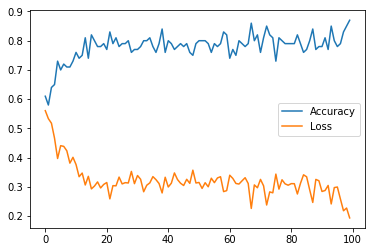

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(range(100), accuracy_am, label="Accuracy")
plt.plot(range(100), loss_am, label="Loss")
plt.legend()
plt.show()

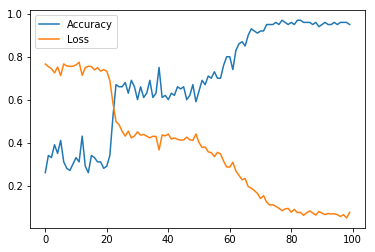

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(range(100), accuracy_sm, label="Accuracy")
plt.plot(range(100), loss_sm, label="Loss")
plt.legend()
plt.show()

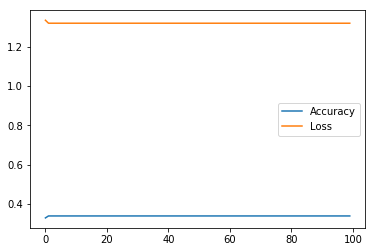

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(range(100), accuracy_rm, label="Accuracy")
plt.plot(range(100), loss_rm, label="Loss")
plt.legend()
plt.show()

## Referencias

* Momentum: https://www.willamette.edu/~gorr/classes/cs449/momrate.html
* Momentum: https://distill.pub/2017/momentum/
* Formula Momentum: https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx